In [23]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scipy.stats as stats

In [105]:
# Cargamos los archivos.

dir_name = "../data/test/52a91fd5d3aed8bac417503b3ce85bdc/639947_19.41_-99.14_"
columns = [ "Year", "Month", "Day", "Hour", "Minute",
    "GHI", "Relative Humidity", "Temperature" ]

# Unimos todos los años.
df = pd.DataFrame( columns = columns )
for y in range(1998, 2022):
    df = df.append( pd.read_csv( dir_name + str(y) + ".csv", skiprows = 2 ) )

# Convertimos a fecha.
df["Date"] = pd.to_datetime( df["Year"].astype(str) + "/"
    + df["Month"].astype(str) + "/" + df["Day"].astype(str)
    + " " + df["Hour"].astype(str) + ":00:00" )

# Corregimos formato de columnas.
df = df.drop(columns[0:5], axis = 1).set_index("Date").astype(float)

df

,GHI,Relative Humidity,Temperature
Date,,,
1998-01-01 00:00:00,0.0,82.38,5.6
1998-01-01 01:00:00,0.0,83.13,5.3
1998-01-01 02:00:00,0.0,83.39,5.0
1998-01-01 03:00:00,0.0,83.16,4.8
1998-01-01 04:00:00,0.0,83.58,4.5
...,...,...,...
2021-12-31 19:00:00,0.0,55.02,9.2
2021-12-31 20:00:00,0.0,59.43,8.3
2021-12-31 21:00:00,0.0,64.04,7.5


In [597]:
# Cálculo del estadístico Finkelstein-Schafer.

# Iteramos para cada variable.
ls_fs = []
for v in [1, 2, 3]:

    # Creamos los dataframes que usaremos.
    fs = pd.DataFrame(columns = range(1, 13), index = range(1998, 2022) )
    fs_y = fs.copy()

    # Iteramos para cada mes y cada año.
    for m in range(1, 13):
        for y in range(1998, 2022):
            # Seleccionamos un mes y un año y
            # calculamos su distribución acumulada.
            df_my = df.loc[ ( df.index.year == y ) & ( df.index.month == m ),
                columns[ v + 4 : v + 5 ] ].sort_values(
                columns[v + 4] ).reset_index( drop = True )
            df_my.index = ( df_my.index + 1 ) / df_my.shape[0]
            # Seleccionamos un mes para todos los años y 
            # calculamos su distribución acumulada.
            df_m = df.loc[ ( df.index.month == 1 ), columns[v + 4 : v + 5]
                ].sort_values( columns[v + 4] ).reset_index( drop = True
                ).reset_index().rename( {"index": "CDF_TOT"}, axis = 1 )
            df_m["CDF_TOT"] = ( df_m["CDF_TOT"] + 1 ) / df_m.shape[0]
            # Interpolamos la información para cada año para poder
            # comparar con la información para todos los años.
            df_m["CDF"] = np.interp(df_m[ columns[v + 4] ].values,
                df_my[ columns[v + 4] ].values, df_my.index)
            # Calculamos el estadístico de Finkelstein-Schafer
            # como la resta de las dos distribuciones acumuladas.
            fs.loc[y, m] = np.abs( df_m["CDF_TOT"] - df_m["CDF"] ).sum()

        # Ordenamos los estadísticos de menor a
        # mayor y anotamos su año correspondiente.
        fs[   m ] = fs[ [m] ].sort_values(m)
        fs_y[ m ] = fs[ [m] ].sort_values(m).index

    
    fs   =   fs.reset_index(drop = True)
    fs_y = fs_y.reset_index(drop = True)
    ls_fs.append( pd.concat( [fs, fs_y], axis = 0, keys = ["FS", "Year"]
        ).swaplevel(0, 1).sort_index() )
    print(ls_fs)

df_fs = pd.concat( ls_fs, axis = 0, keys = columns[5:8] )

tot_fs = df_fs.loc[ (slice(None), slice(None), "FS") ].groupby(level=1).sum()
tot_y = tot_fs.copy()

for m in range(1, 13): tot_y[ m ] = tot_fs[ [m] ].sort_values(m).index

tot = pd.concat( [tot_fs, tot_y], axis = 0, keys = ["FS", "Year"]
        ).swaplevel(0, 1).sort_index()

df_fs = pd.concat( [*ls_fs, tot], axis = 0, keys = columns[5:8] + ["Total"] )
df_fs.loc[ (slice(None), slice(None), "Year") ] = (
    df_fs.loc[ (slice(None), slice(None), "Year") ].astype(int) )

df_fs.index = df_fs.index.set_levels( range( 1,
    df_fs.index.get_level_values(1).shape[0] + 1 ), level = 1)

df_fs

[                  1            2            3            4            5   \
0  FS    2735.931027  3013.874029  3014.971116  2836.677754  2899.125771   
   Year         2019         2018         2015         2018         2014   
1  FS    2792.259957  2765.540135   2803.40509  2735.234826  2701.931639   
   Year         2021         2020         2016         2020         2015   
2  FS    2715.918346  2861.774327  2784.374808  2721.895651  2417.698962   
   Year         2020         2019         2004         2007         2000   
3  FS    2687.323605  2640.562535  2900.966459  2645.573265  2518.471169   
   Year         2014         2012         2020         2021         2009   
4  FS    2766.420781  2631.222712  2846.555954  2726.316135  2643.228726   
   Year         2008         2010         2005         2015         2017   
5  FS    2760.420922  2927.441066  2848.417572  2554.902687  2678.495573   
   Year         2018         2002         2019         2019         2021   
6  FS    27

1            2            3             4   \
GHI   1  FS    2735.931027  3013.874029  3014.971116   2836.677754   
         Year         2019         2018         2015          2018   
      2  FS    2792.259957  2765.540135   2803.40509   2735.234826   
         Year         2021         2020         2016          2020   
      3  FS    2715.918346  2861.774327  2784.374808   2721.895651   
...                    ...          ...          ...           ...   
Total 22 Year            0            0           21            15   
      23 FS    3692.056901  6796.047684  9362.667524  10277.051984   
         Year            6           21           22             0   
      24 FS    4568.139079  7426.867023  9674.484306  10698.220029   
         Year           12           15           23            21   

                        5             6             7             8   \
GHI   1  FS    2899.125771   2599.091772    2317.67008   2192.930593   
         Year         2014          2003          2011          2021   
      2  FS    2701.931639   2553.905434   2267.705705   2175.392436   
         Year         2015          2004          2008          2020   
      3  FS    2417.698962   2200.813625   2572.182191   2248.342003   
...                    ...           ...           ...           ...   
Total 22 Year           12            18            10            12   
      23 FS    9369.331849   9056.151553  10100.566585  10797.988022   
         Year           21            16            13            10   
      24 FS    7987.498878  10261.680236  10434.321223  10903.433818   
         Year            0             5            12            18   

                         9             10           11           12  
GHI   1  FS     2472.542975   2978.295251  2684.069363  2749.848013  
         Year          2021          2021         2019         1999  
      2  FS      2434.38074   2779.719666  2675.979202  2730.739634  
         Year          2019          2019         1999         2003  
      3  FS     2454.869769   2819.555331  2692.761044  2743.161201  
...                     ...           ...          ...          ...  
Total 22 Year            11             4           21           12  
      23 FS    10951.186053   6995.090903  4631.624979  4954.706451  
         Year            15            20           17           15  
      24 FS    11365.413468  10115.516548  5471.322086  5267.025827  
         Year             0             0            0           17  

[192 rows x 12 columns]

In [591]:
import itertools as it

df_d = df.resample("D").mean()
df_d["GHI"] = df["GHI"].resample("D").sum()
df_run = [ df_d.copy(), df_d.copy() ]

def comp(x):
    if i == 0: return x <= p
    else:      return x >= p

for i in range( len(df_run) ):
    for v in [1, 2, 3]:
        for m in range(1, 13):
            df_m = df_d.loc[ df_d.index.month == m, columns[v + 4 : v + 5]
                ].sort_values( columns[v + 4] ).reset_index( drop = True
                ).reset_index().rename( {"index": "CDF_TOT"}, axis = 1 )
            df_m["CDF_TOT"] = ( df_m["CDF_TOT"] + 1 ) / df_m.shape[0]

            p = df_m.loc[ (df_m["CDF_TOT"] <= (i+1)/3 + 1e-10)
                & (df_m["CDF_TOT"] >= (i+1)/3 - 1e-10), columns[v + 4]
                ].values[0]

            df_run[i].loc[ df_d.index.month == m, columns[v + 4] ] = np.where(
                df_d.loc[ ( df_d.index.month == m ), columns[v + 4]
                    ].apply(comp),
                np.ones_like( df_d.loc[ ( df_d.index.month == m ),
                    columns[v + 4] ] ),
                np.zeros_like( df_d.loc[ ( df_d.index.month == m ),
                    columns[v + 4] ] ) )
            
df_r = pd.concat( df_run, axis = 1, keys = ["0.33", "0.66"] ).swaplevel(
    0, 1, axis = 1 ).sort_index(axis = 1)


a = pd.DataFrame(index = range(1998, 2022), columns = range(1, 13) )
b = pd.concat( [a] * 3, axis = 1, keys = ["number", "max", "pass"]
    ).swaplevel(0, 1, axis = 1).sort_index(axis = 1)
df_nr = pd.concat( [b] * len(columns), axis = 1, keys = columns[5:8] )
                  
for v in [1, 2, 3]:
    for m in range(1, 13):
        for y in range(1998, 2022):
            a = df_r.loc[ (df_r.index.year == y) & (df_r.index.month == m),
                ( columns[v + 4], "0.33") ]
            nr = pd.DataFrame( (i, len(list(g))) for i, g in it.groupby(a) )
            nr = nr.where( nr.loc[:, 0] == 1, np.nan ).dropna()
            df_nr.loc[y, (columns[v + 4], m)] = [
                nr.loc[:, 1].max(), nr.loc[:, 0].sum(), np.nan ]

df_nr.loc[:, (slice(None), slice(None), "pass")] = ~(
    ( (df_nr.max() == df_nr).loc[
    :, (slice(None), slice(None), "max") ] ).values
    + ( (df_nr.max() == df_nr).loc[
    :, (slice(None), slice(None), "number") ] ).values )


reject = pd.DataFrame(index = range(1998, 2022), columns = range(1, 13) )

for m in range(1, 13):
    reject.loc[:, m] = df_nr.loc[ :, ( slice(None), m, "pass" ) ].all(axis = 1)
reject = reject.where(reject == False, np.nan)

reject

,1,2,3,4,5,6,7,8,9,10,11,12
1998,False,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN
1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,False
2000,NaN,NaN,NaN,NaN,False,NaN,False,False,NaN,NaN,NaN,NaN
2001,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,False,False
2003,False,NaN,NaN,False,NaN,False,NaN,False,NaN,NaN,NaN,False
2004,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
2005,NaN,False,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN
2006,NaN,False,NaN,NaN,False,NaN,NaN,False,False,False,NaN,False
2007,NaN,False,NaN,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN


In [592]:
df_list = pd.DataFrame(columns = ["Year"], index = range(1, 13))

n = 1
for m in range(1, 13):
    if not( df_fs.loc[ ("Total", n, "Year"), m ] in reject[m].dropna().index ):
        df_list.loc[m] = df_fs.loc[ ("Total", n, "Year"), m ]

for n in range(2, 6):
    for m in df_list[ df_list.isnull().any(axis = 1) ].index:
        if not( df_fs.loc[ ("Total", n, "Year"), m ]
            in reject[m].dropna().index ):
            df_list.loc[m] = df_fs.loc[ ("Total", n, "Year"), m ]

df_list

,Year
1,2008
2,2015
3,2004
4,2004
5,2001
6,2006
7,1999
8,2009
9,2011
10,2010


In [78]:
d = 0
dist_f = [stats.norm, stats.gamma, stats.expon, stats.beta]

dist = dist_f[d]( *dist_f[d].fit( df[ columns[v + 4] ] ) )
print("Kolmogorov-Smirnoff pvalue: " +
    f"{stats.kstest(df[ columns[v + 4] ], dist.cdf)[1]}" )

Kolmogorov-Smirnoff pvalue: 0.0


Distribución seleccionada: Normal
Kolmogorov-Smirnoff pvalue: 0.0


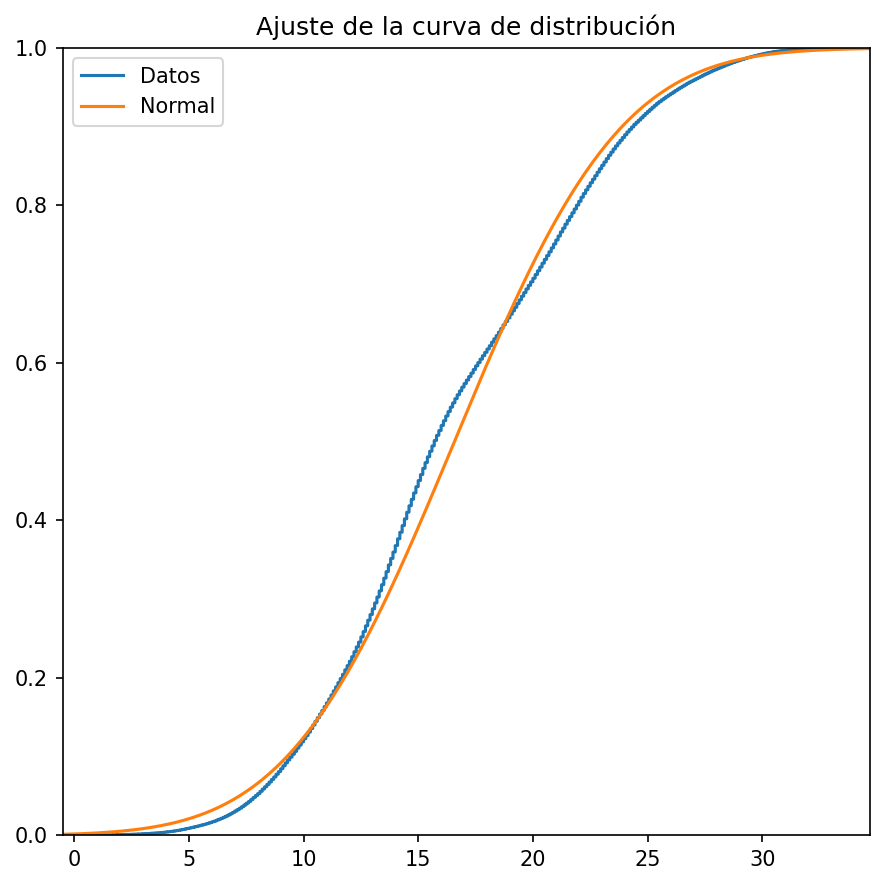

In [109]:
# Seleccionamos la variable.
# 1: GHI, 2: Relative Humidity, 3: Temperature.
v = 3

# Seleccionamos una distribución y probamos la bondad de ajuste.
d = 0
dist_f = [ stats.norm, stats.gamma, stats.expon,   stats.beta ]
dist_n = [ "Normal",   "Gamma",     "Exponencial", "Beta"     ]

dist = dist_f[d]( *dist_f[d].fit( df[ columns[v + 4] ] ) )
print(f"Distribución seleccionada: {dist_n[d]}")
print("Kolmogorov-Smirnoff pvalue: " +
    f"{stats.kstest(df[ columns[v + 4] ], dist.cdf)[1]}" )

# Graficamos
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

n = df[ columns[v + 4] ].sort_values()
ax.plot( n, np.linspace( 1 / df.shape[0] , 1, df.shape[0]) )
ax.plot( n, dist.cdf(n) )

ax.set_title("Ajuste de la curva de distribución")
ax.set_xlim( df[ columns[v + 4] ].min(), df[ columns[v + 4] ].max() )
ax.set_ylim(0, 1)
ax.legend( ["Datos", dist_n[d]] )
fig.tight_layout()
plt.show()